In [1]:
import networkx as nx
import pandas as pd
import numpy as np

##### Extracting and building a graph (ego) where the central node represents the 'world' with relative weights, edges with other countries. 

In [2]:
# constructing the graph for a measure with a give year:
def createGraph(nodes_list, year, measure, df):
    G = nx.Graph()
    G.add_nodes_from(nodes_list)
    yr = year
    earths = df.query("year == @yr and countryCode == 5001 and record == @measure")[['value']] # countryCode for the record 'World' is 5001.
    earths = earths.squeeze()
    for c in nodes_list:
        if c == 5001:
            continue
        c_earths = df.query("year == @yr and countryCode == @c and record == @measure")[['value']]
        if not c_earths.empty and (not np.isnan(c_earths.values)): # check if the record exists and not a NA value.
                c_earths = c_earths.squeeze()
                wt = round(c_earths / earths, 3)
                G.add_edge(c, 5001, weight=wt)

    return G

##### Extracting and building a graph where the nodes are countries and the edges, weights represent the relative differences (scaled down) between measures. 

In [3]:
def graph_Relative(nodes_list, year, measure, df):
    G = nx.Graph()
    G.add_nodes_from(nodes_list)
    yr = year

    # Batch retrieval of data for all nodes
    node_data = df.query("year == @yr and countryCode in @nodes_list and record == @measure")

    for c1 in nodes_list:
        for c2 in nodes_list:
            if c1 != c2 and not G.has_edge(c1, c2):
                if c1 == 5001 or c2 == 5001: # Skipping the world nodes
                    continue

                c1_earth = node_data.query("countryCode == @c1")['value'].values
                c2_earth = node_data.query("countryCode == @c2")['value'].values

                # Check if both nodes have valid data
                if len(c1_earth) > 0 and not np.isnan(c1_earth[0]) and len(c2_earth) > 0 and not np.isnan(c2_earth[0]):
                    wt = round((c1_earth[0] - c2_earth[0]) / 1e6, 3)
                    G.add_edge(c1, c2, weight=wt)
    return G


##### Plotting an ego-graph where the central node is world.
##### Referred from https://networkx.org/documentation/stable/auto_examples/drawing/plot_ego_graph.html

In [4]:
import matplotlib.pyplot as plt
from operator import itemgetter

def plt_ego_graph(G, year, measure, i):
    node_and_degree = G.degree()
    (largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]  # finding the node with largest degree

    edge_weights = [G[u][v]["weight"] for u, v in G.edges()]  # fetching edge-weights

    # plotting the graph as 'ego' graph
    hub_ego = nx.ego_graph(G, largest_hub)
    pos = nx.spring_layout(hub_ego)
    plt.subplot(3, 3, i)
    plt.title(f"Graph: Measure - {measure} for year - {year}")

    nx.draw(
        hub_ego,
        pos,
        node_color="b",
        node_size=50,
        width=edge_weights * 3,
        with_labels=False,
    )
    options = {"node_size": 300, "node_color": "r"}
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], **options)


##### Network Measures

In [5]:
def network_properties(G):
    # Number of nodes
    num_nodes = len(G.nodes())
    print("Number of nodes:", num_nodes)

    # Number of edges
    num_edges = len(G.edges())
    print("Number of edges:", num_edges)

    # Average degree or Degree Centrality
    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    print("Average degree:", avg_degree)

    # Density
    density = nx.density(G)
    print("Density:", density)

    # Clustering coefficient
    clustering_coefficient = nx.average_clustering(G)
    print("Average clustering coefficient:", clustering_coefficient)

    # Closeness Centrality
    closeness =  nx.closeness_centrality(G)
    print("Closeness Centrality:", closeness)

    connected = nx.is_connected(G)
    print("Is the graph connected?",connected)

##### Reading the dataframe as well as contructing the graphs

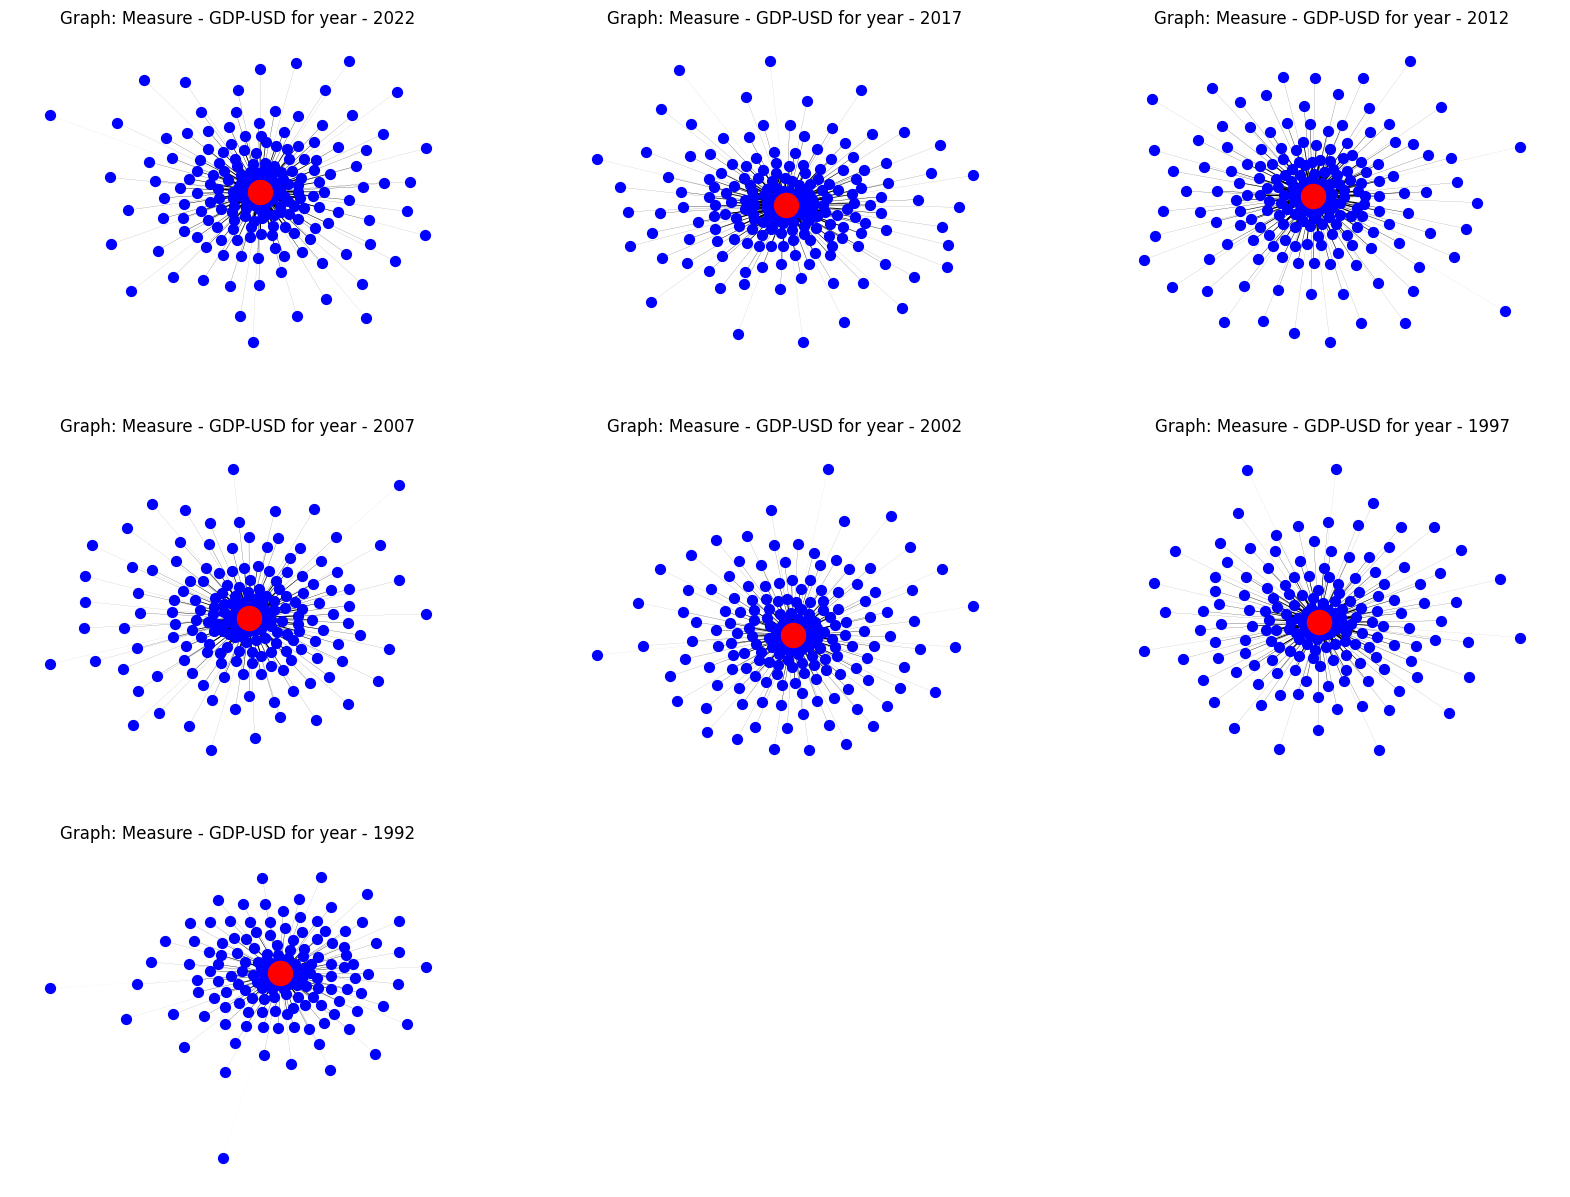

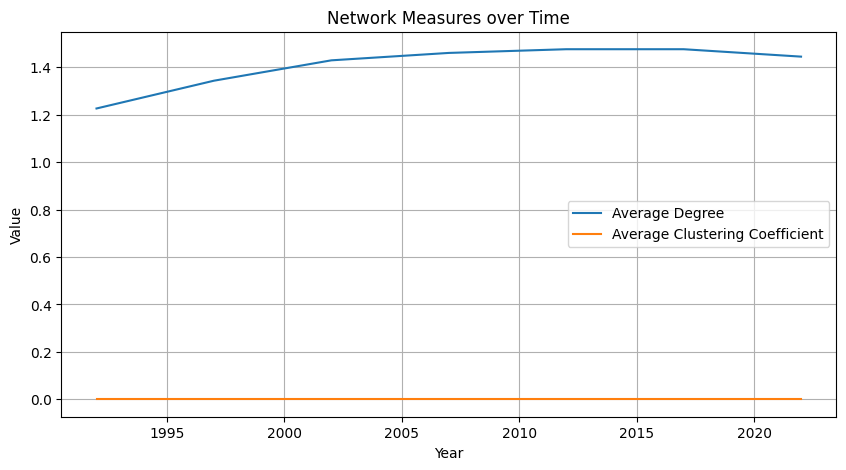

In [6]:
df = pd.read_csv('main_df.csv', header=0, sep=',')

countries_code = list(df['countryCode'].unique())
plt.figure(figsize=(20,15))
plt.tight_layout()

"""i = 1
measure = 'Earths'
for year in range(2022, 1990, -5):
    G = createGraph(countries_code, year, measure, df)
    plt_ego_graph(G, year, measure, i)
    network_properties(G)
    i+=1
"""

# Create lists to store network measures for each graph
avg_degrees = []
avg_clustering_coeffs = []

i = 1
measure = 'GDP-USD'
for year in range(2022, 1990, -5):
    G = createGraph(countries_code, year, measure, df)
    plt_ego_graph(G, year, measure, i)
    num_nodes = len(G.nodes())
    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    avg_clustering_coeff = nx.average_clustering(G)

    # Append measures to the respective lists
    avg_degrees.append(avg_degree)
    avg_clustering_coeffs.append(avg_clustering_coeff)


    i += 1

# Convert the lists to numpy arrays for easier manipulation
avg_degrees = np.array(avg_degrees)
avg_clustering_coeffs = np.array(avg_clustering_coeffs)

# Plotting network measures
plt.figure(figsize=(10, 5))
plt.plot(range(2022, 1990, -5), avg_degrees, label='Average Degree')
plt.plot(range(2022, 1990, -5), avg_clustering_coeffs, label='Average Clustering Coefficient')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Network Measures over Time')
plt.legend()
plt.grid(True)
plt.show()


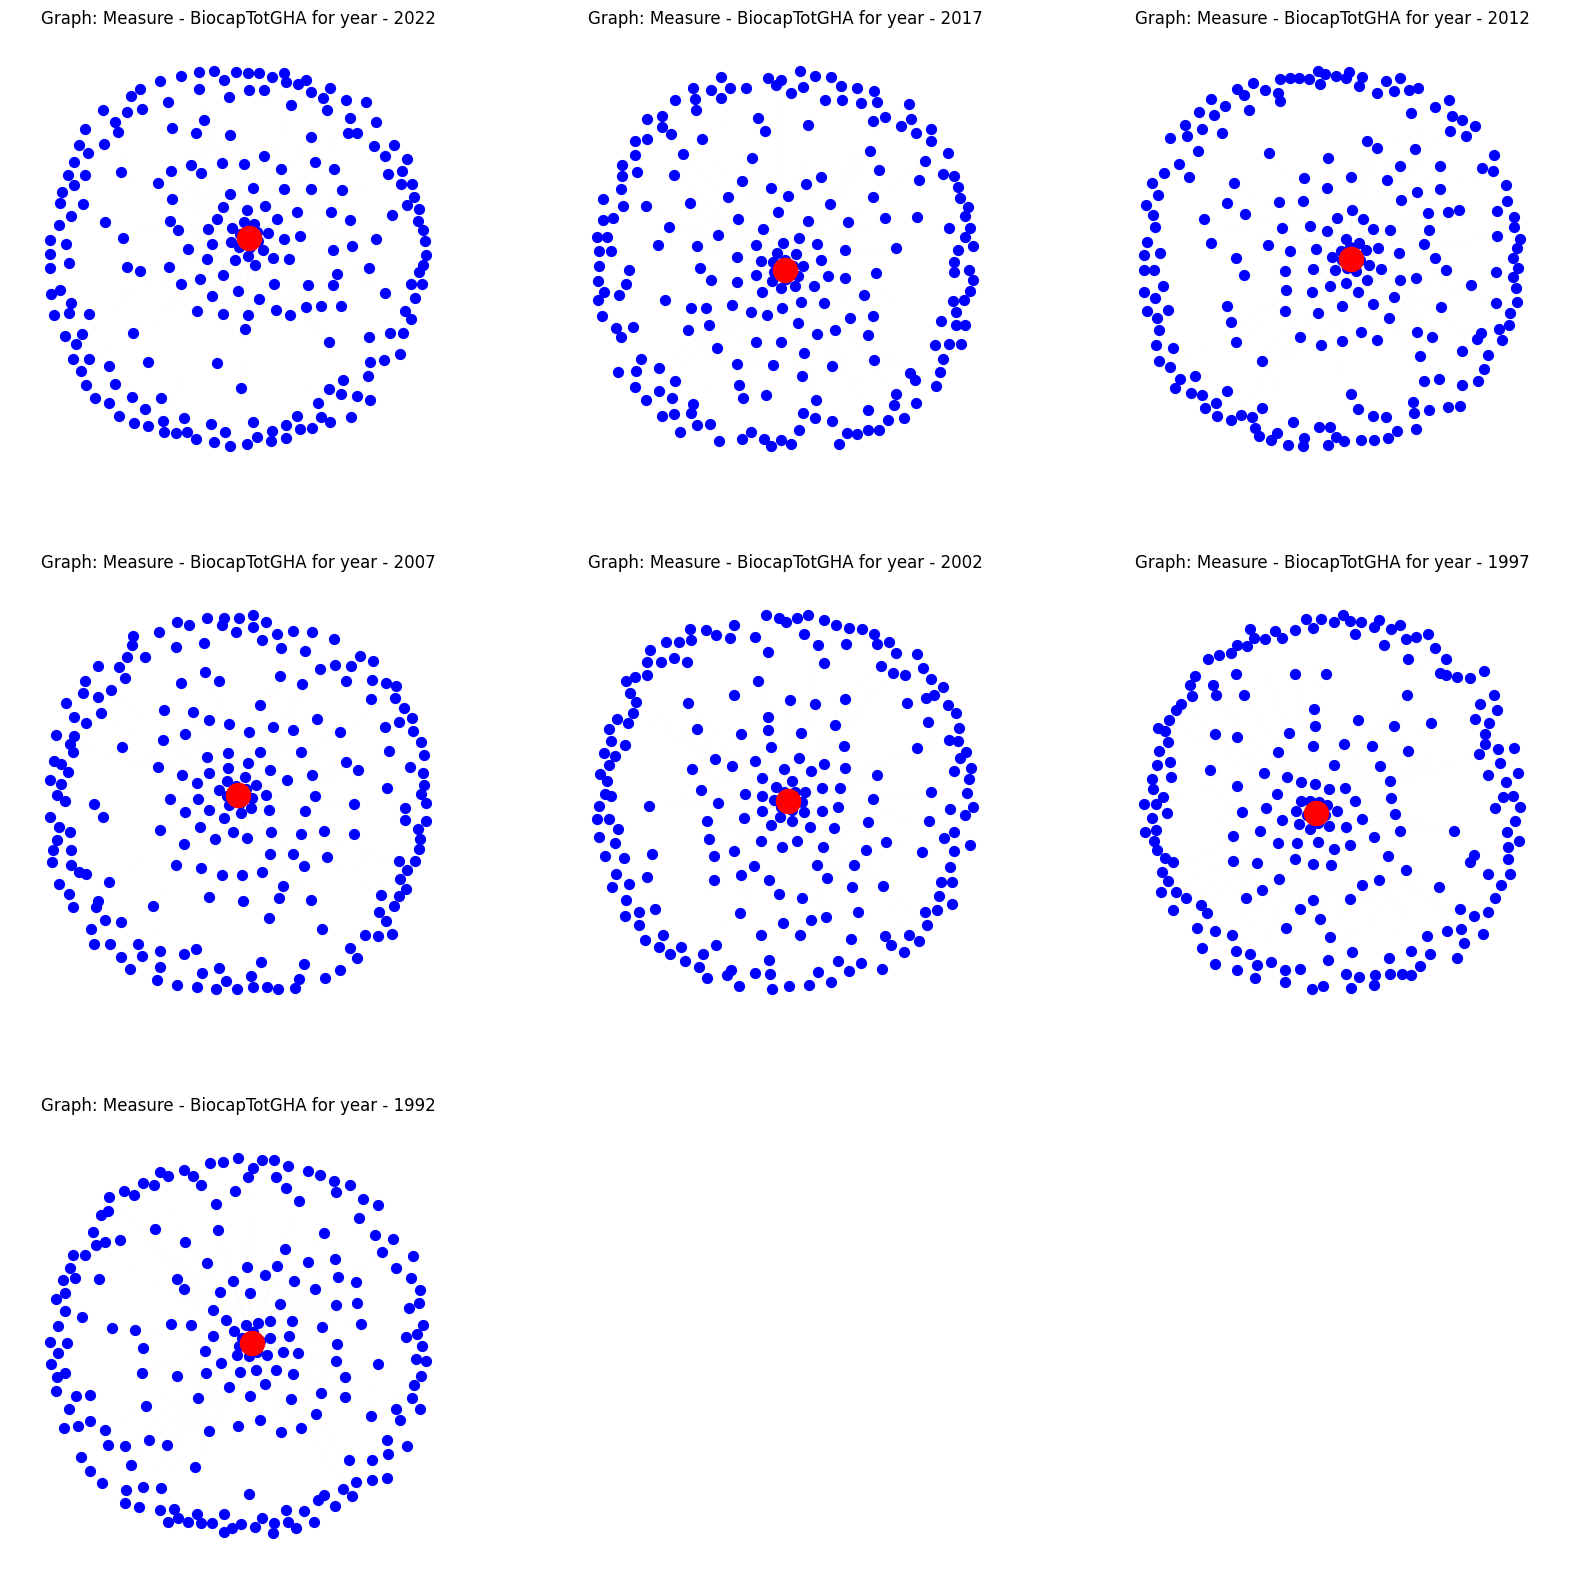

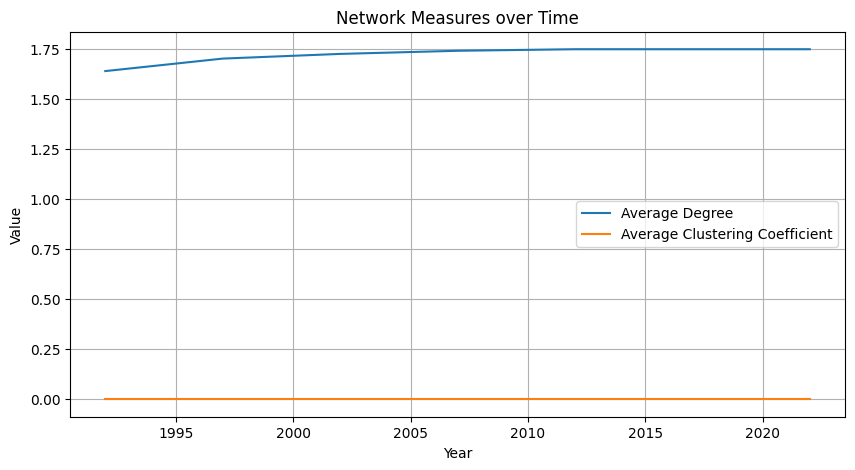

In [7]:
# measure - Biocapacity
plt.figure(figsize=(20,20))
plt.tight_layout()

# Create lists to store network measures for each graph
avg_degrees = []
avg_clustering_coeffs = []

i = 1
measure = 'BiocapTotGHA'
for year in range(2022, 1990, -5):
    G = createGraph(countries_code, year, measure, df)
    plt_ego_graph(G, year, measure, i)
    num_nodes = len(G.nodes())
    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    avg_clustering_coeff = nx.average_clustering(G)

    # Append measures to the respective lists
    avg_degrees.append(avg_degree)
    avg_clustering_coeffs.append(avg_clustering_coeff)


    i += 1

# Convert the lists to numpy arrays for easier manipulation
avg_degrees = np.array(avg_degrees)
avg_clustering_coeffs = np.array(avg_clustering_coeffs)

# Plotting network measures
plt.figure(figsize=(10, 5))
plt.plot(range(2022, 1990, -5), avg_degrees, label='Average Degree')
plt.plot(range(2022, 1990, -5), avg_clustering_coeffs, label='Average Clustering Coefficient')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Network Measures over Time')
plt.legend()
plt.grid(True)
plt.show()

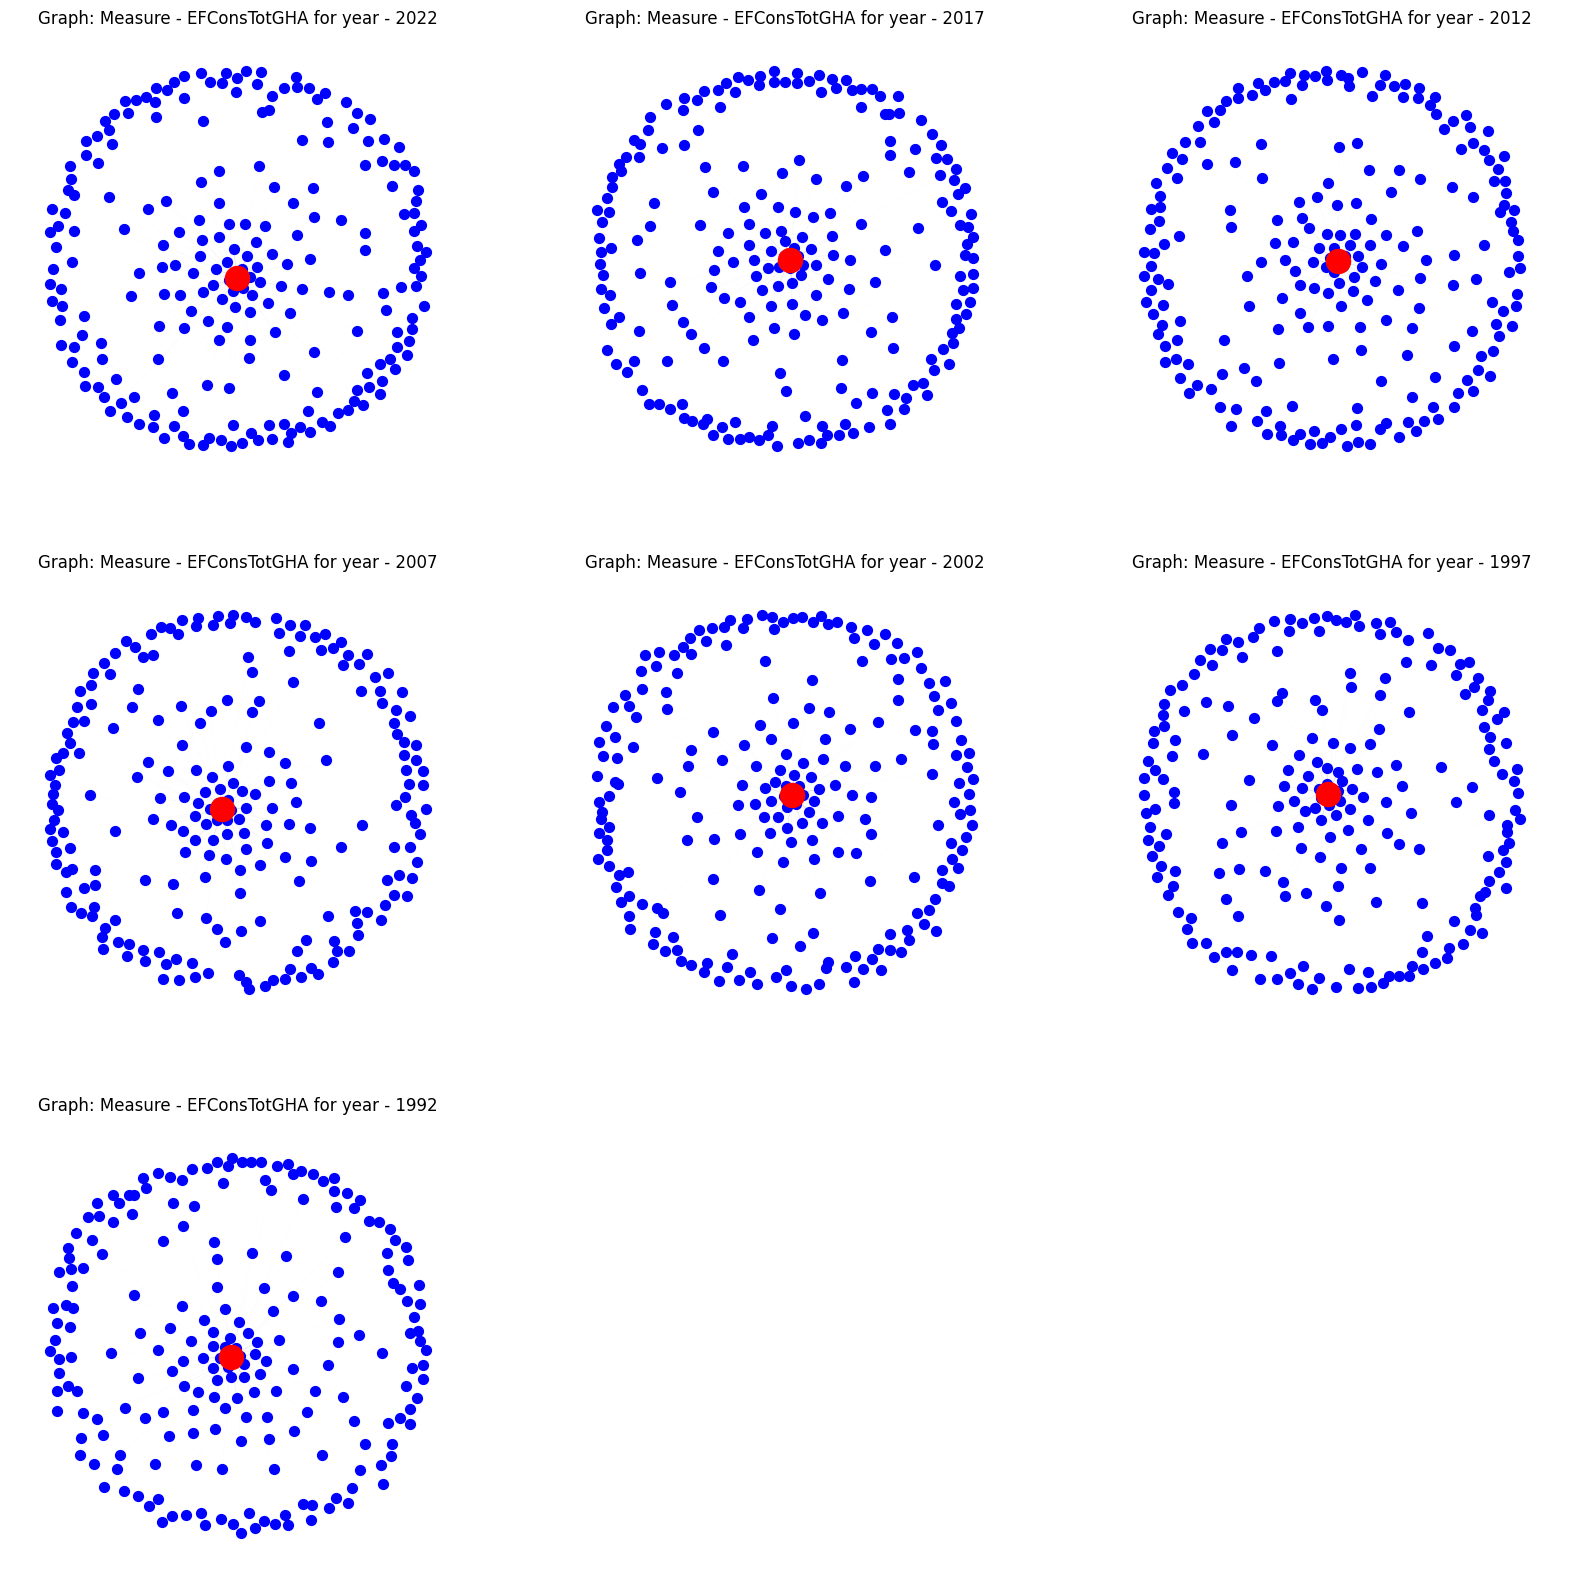

In [8]:
# measure - 'Ecological Footprint (Total)'
plt.figure(figsize=(20,20))
plt.tight_layout()

i = 1
measure = 'EFConsTotGHA'
for year in range(2022, 1990, -5):
    G = createGraph(countries_code, year, measure, df)
    plt_ego_graph(G, year, measure, i)
    #network_properties(G) You can find the network properties using this code.
    i+=1

##### Constructing a random sub-graph to represent a sample of the larger network.

In [9]:
import random
from matplotlib.lines import Line2D


def plotSubGraph_relative(G, measure):
# custom legend options (https://stackoverflow.com/questions/39500265/how-to-manually-create-a-legend)
    colors = ['red', 'green']
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
    labels = ['Negative (representing lower measure)', 'Positive (representing higher measure)']

    sub_nodes = random.sample(G.nodes(), 50) # Considering a sample of the nodes, to avoid large-graph rendering issues
    sub_edges = []
    for node in sub_nodes:
        sub_edges.extend(G.edges(node))

    # Create a subgraph
    G_sub = G.subgraph(sub_nodes + sub_edges)
    pos = nx.spring_layout(G_sub)
    nx.draw_networkx_nodes(G_sub, pos, node_size=50, node_color='blue', alpha=0.6)

    edge_colors = []
    for u, v, d in G_sub.edges(data=True):
        if 'weight' in d:
            if d['weight'] > 0:
                edge_colors.append('green')
            else:
                edge_colors.append('red')

    nx.draw_networkx_edges(G_sub, pos, width=1.0, alpha=0.6, edge_color=edge_colors)
    plt.title(f'A relative sampled graph betweeen countries with measure: {measure}')
    plt.legend(lines, labels,loc=3)
    plt.show()
    return G_sub

In [10]:
def average_weight_gh(G):
    total_weight = sum(weight for _, _, weight in G.edges(data='weight'))
    average_weight = total_weight / G.number_of_edges()
    return average_weight

def negative_wt_proportion(G):
    negative_weight_count = sum(1 for _, _, data in G.edges(data=True) if data['weight'] < 0)

    # Calculate the percentage of negative weight edges
    total_edges = G.number_of_edges()
    percentage_negative = (negative_weight_count / total_edges) * 100
    return percentage_negative

In [11]:
year = 2022
measure = 'BiocapTotGHA'
G = graph_Relative(countries_code, year, measure, df)

256
24976
Average weight within the graph: BiocapTotGHA, -160.198262
Negative weight proportion within the graph: BiocapTotGHA, 58.476137


C:\Users\sharm\AppData\Local\Temp\ipykernel_35728\462675211.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sub_nodes = random.sample(G.nodes(), 50) # Considering a sample of the nodes, to avoid large-graph rendering issues


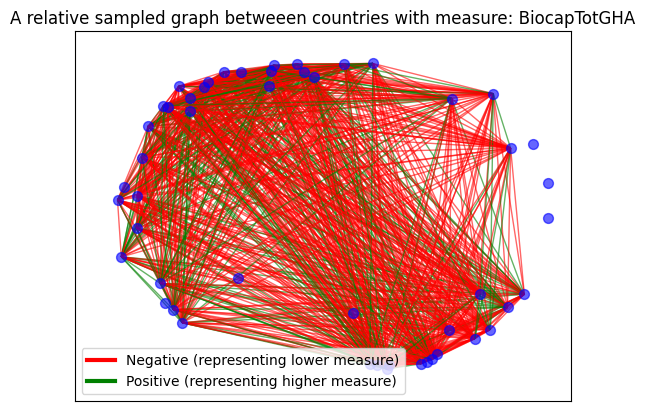

In [12]:
print(len(G.nodes()))
print(len(G.edges()))

print(f'Average weight within the graph: {measure}, {average_weight_gh(G):3f}')
print(f'Negative weight proportion within the graph: {measure}, {negative_wt_proportion(G):3f}')

G_sub = plotSubGraph_relative(G, measure)


In [13]:
network_properties(G_sub)

Number of nodes: 50
Number of edges: 861
Average degree: 34.44
Density: 0.7028571428571428
Average clustering coefficient: 0.84
Closeness Centrality: {1: 0.8367346938775511, 3: 0.8367346938775511, 6: 0.0, 264: 0.0, 137: 0.8367346938775511, 11: 0.8367346938775511, 13: 0.8367346938775511, 142: 0.0, 143: 0.8367346938775511, 22: 0.0, 27: 0.8367346938775511, 35: 0.8367346938775511, 37: 0.8367346938775511, 166: 0.8367346938775511, 169: 0.8367346938775511, 170: 0.8367346938775511, 47: 0.8367346938775511, 49: 0.8367346938775511, 178: 0.8367346938775511, 51: 0.0, 185: 0.8367346938775511, 186: 0.0, 60: 0.8367346938775511, 189: 0.8367346938775511, 62: 0.0, 191: 0.8367346938775511, 201: 0.8367346938775511, 73: 0.8367346938775511, 203: 0.8367346938775511, 2000: 0.8367346938775511, 84: 0.8367346938775511, 87: 0.8367346938775511, 217: 0.8367346938775511, 90: 0.8367346938775511, 91: 0.8367346938775511, 220: 0.8367346938775511, 351: 0.8367346938775511, 229: 0.8367346938775511, 102: 0.8367346938775511, 

C:\Users\sharm\AppData\Local\Temp\ipykernel_35728\462675211.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sub_nodes = random.sample(G.nodes(), 50) # Considering a sample of the nodes, to avoid large-graph rendering issues


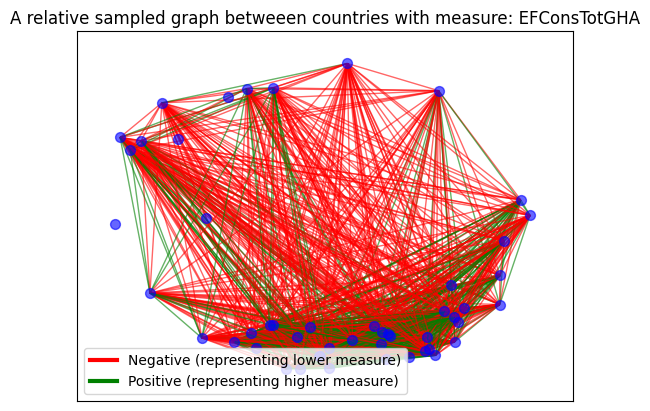

Average weight within the graph: EFConsTotGHA, -326.172208
Negative weight proportion within the graph: EFConsTotGHA, 60.009609


In [14]:
# Different Measure (year - 2022)

year = 2022
measure = 'EFConsTotGHA'
G = graph_Relative(countries_code, year, measure, df)

plotSubGraph_relative(G, measure)

print(f'Average weight within the graph: {measure}, {average_weight_gh(G):3f}')
print(f'Negative weight proportion within the graph: {measure}, {negative_wt_proportion(G):3f}')

##### Simulating Network Models (Small-World and Pref.Attachment)

In [15]:
def small_world_model(n, k, p):
    G = nx.watts_strogatz_graph(n, k, p)
    return G

# Preferential Attachment Model
def preferential_attachment_model(n, m):
    G = nx.barabasi_albert_graph(n, m)
    return G

In [16]:
small_world = small_world_model(50, 10, (0.82/49))

##### Plotting the network models

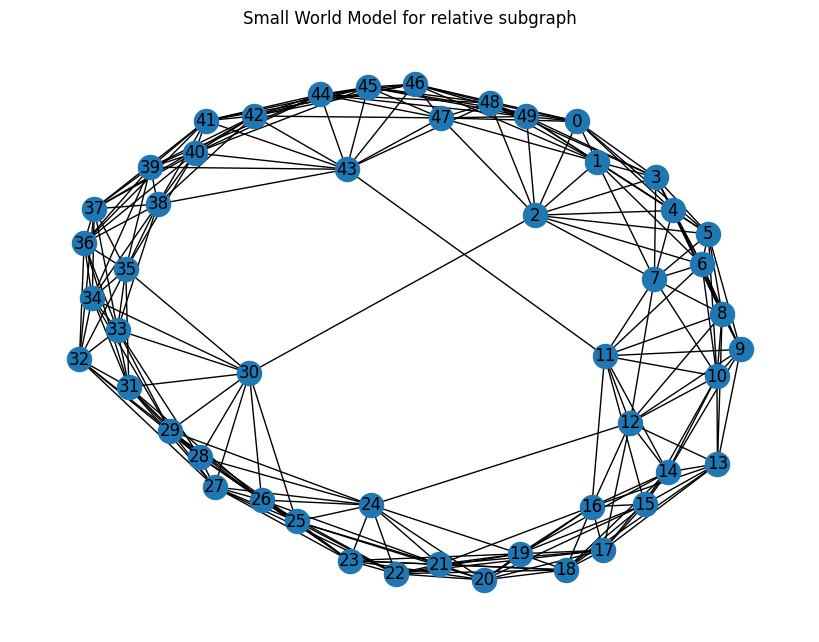

In [17]:
def plot_graph(G, title):
    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True)
    plt.title(title)
    plt.show()
plot_graph(small_world, "Small World Model for relative subgraph")

In [18]:
measures_small_world = network_properties(small_world)
avg_path_length =  nx.average_shortest_path_length(small_world)
print("Average path length:", avg_path_length)

Number of nodes: 50
Number of edges: 250
Average degree: 10.0
Density: 0.20408163265306123
Average clustering coefficient: 0.6371515151515156
Closeness Centrality: {0: 0.3888888888888889, 1: 0.4049586776859504, 2: 0.4537037037037037, 3: 0.3951612903225806, 4: 0.3951612903225806, 5: 0.3951612903225806, 6: 0.4083333333333333, 7: 0.4224137931034483, 8: 0.4016393442622951, 9: 0.3983739837398374, 10: 0.4016393442622951, 11: 0.45794392523364486, 12: 0.44144144144144143, 13: 0.35766423357664234, 14: 0.3951612903225806, 15: 0.392, 16: 0.3951612903225806, 17: 0.3656716417910448, 18: 0.362962962962963, 19: 0.362962962962963, 20: 0.3656716417910448, 21: 0.3656716417910448, 22: 0.35507246376811596, 23: 0.3602941176470588, 24: 0.4117647058823529, 25: 0.4049586776859504, 26: 0.4083333333333333, 27: 0.4117647058823529, 28: 0.4152542372881356, 29: 0.4188034188034188, 30: 0.4537037037037037, 31: 0.3983739837398374, 32: 0.362962962962963, 33: 0.3951612903225806, 34: 0.392, 35: 0.3828125, 36: 0.362962962

In [19]:
pref_attach = preferential_attachment_model(50, 4)

measures_pref_attach = network_properties(pref_attach)
avg_path_length =  nx.average_shortest_path_length(pref_attach)
print("Average path length:", avg_path_length)

Number of nodes: 50
Number of edges: 184
Average degree: 7.36
Density: 0.15020408163265306
Average clustering coefficient: 0.27966634803105395
Closeness Centrality: {0: 0.6712328767123288, 1: 0.494949494949495, 2: 0.5568181818181818, 3: 0.6805555555555556, 4: 0.47115384615384615, 5: 0.5903614457831325, 6: 0.6125, 7: 0.5632183908045977, 8: 0.5632183908045977, 9: 0.5104166666666666, 10: 0.5444444444444444, 11: 0.5568181818181818, 12: 0.5051546391752577, 13: 0.5051546391752577, 14: 0.5, 15: 0.4803921568627451, 16: 0.49, 17: 0.5, 18: 0.5104166666666666, 19: 0.5444444444444444, 20: 0.5051546391752577, 21: 0.49, 22: 0.4803921568627451, 23: 0.5157894736842106, 24: 0.4260869565217391, 25: 0.47115384615384615, 26: 0.4260869565217391, 27: 0.4666666666666667, 28: 0.494949494949495, 29: 0.5, 30: 0.4537037037037037, 31: 0.47572815533980584, 32: 0.4336283185840708, 33: 0.47572815533980584, 34: 0.48514851485148514, 35: 0.44545454545454544, 36: 0.48514851485148514, 37: 0.4803921568627451, 38: 0.441441

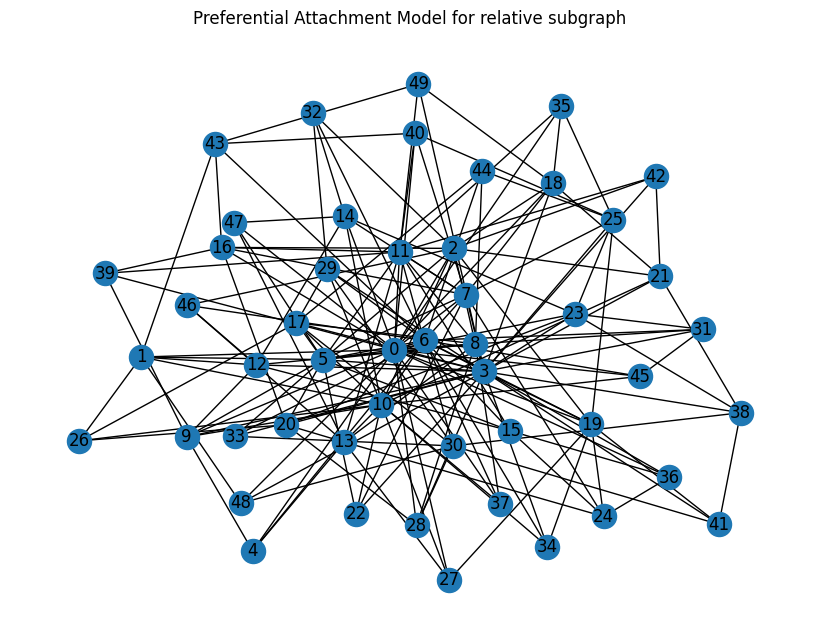

In [20]:
plot_graph(pref_attach, "Preferential Attachment Model for relative subgraph")

##### Identfying communities using Girvan-Newmann algorithm

In [21]:
def most_central_edge(G):
    centrality = nx.edge_betweenness_centrality(G, weight="weight")
    return max(centrality, key=centrality.get)

def detect_communities(G):
    # Using the Girvan-Newman algorithm for community detection
    comp = nx.community.girvan_newman(G, most_valuable_edge=most_central_edge)
    return tuple(sorted(c) for c in next(comp))

communities = detect_communities(G_sub) #Use this code to find communities of any of the above graph
print(communities)

([1, 3, 11, 13, 27, 35, 37, 47, 49, 60, 73, 84, 87, 90, 91, 102, 106, 112, 124, 126, 137, 143, 166, 169, 170, 178, 185, 189, 191, 201, 203, 217, 220, 229, 1003], [6], [264], [142], [22], [51], [186], [62], [231, 351, 1005, 1009, 1014, 1015, 2000], [1008])
